# Obtaining BO results from different molecule representation

## Step 1: Load Datasets
In the present demonstration, we will use a model dataset *LIPO* correlating molecular structure with lipophilicity, a typical quantitative-structure property relationship (QSPR) modelling task.

Hersey, A. ChEMBL Deposited Data Set - AZ dataset; 2015. https://doi.org/10.6019/chembl3301361

In [1]:
import numpy as np
from data_helper import gen_data_feat,load_lipo_feat
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

featurizer_name = 'rdkit'
# Here we adapt 2/98 split for training and candidate set
partition_ratio = 0.1

# Load from pre-featurized data
X, y = load_lipo_feat(filename='data/lipo_{}.csv'.format(featurizer_name))

# Split data into start training and candidate sets
X_train, X_candidate, y_train, y_candidate = train_test_split(
    X, y,
    test_size=1-partition_ratio,
    random_state=1,
    shuffle=True
)

# Standardize input data if needed
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_candidate = scaler.transform(X_candidate)

# Apply PCA to reduce dimensionality (optional)
# pca = PCA(n_components=50)
# X_train = pca.fit_transform(X_train)
# X_cadidate = pca.transform(X_cadidate)

print('Training set size:', X_train.shape)
print('Candidate set size:', X_candidate.shape)

print('Best Observed in Training Set:', y_train.max())
print('Best Observed in Full Set:', y.max())

Training set size: (420, 198)
Candidate set size: (3780, 198)
Best Observed in Training Set: 1.8142925537876984
Best Observed in Full Set: 1.9299001765826398


## Step2: Prepare for Surrogate

We here first import surrogates to do a preliminary modelling test

In [2]:
from sklearn.metrics import r2_score

from surrogates import Surrogate
from surrogates import RandomForestSurrogate
from surrogates import GPTanimotoSurrogate
from surrogates import GPRQSurrogate

/Users/fanjin/anaconda3/envs/bo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Define surrogate model.
test_surrogate = GPRQSurrogate()
test_surrogate.load_data(train_x=X_train, train_y=y_train)

# Fit surrogate model.
test_surrogate.fit()

# Get means and uncertainties from surrogate model.
means, uncertainties = test_surrogate.predict_means_and_stddevs(X_candidate)
print(f'Test shape: {X_candidate.shape}')
print(f'Mean shape: {means.shape}')
print(f'Uncertainty shape: {uncertainties.shape}')

# Report results of model fit.
print(f'R^2 Score on test set: {r2_score(y_candidate, means)}')

# Step3: Setup BO

We first run on a single trial of BO, the iteration will be 10 rounds.

In [3]:
from surrogates import acqf_EI
######################
###Define setting#####
######################

num_iter = 20
num_trial = 1


###################################
#####Train Surrogates##############
###################################

my_surrogate = GPRQSurrogate()
my_surrogate.load_data(train_x=X_train, train_y=y_train)
best_observed = y_train.max()

#initialize the containers of new points and best observed values
X_new_candidates , y_new_candidates= [],[]
current_bests = []

for iter in range(1,num_iter+1):

    # Fit surrogate model.
    my_surrogate.fit()

    ######################################################################
    #####Eval element in candidate set and max Acquisition function#######
    ######################################################################

    means, uncertainties = my_surrogate.predict_means_and_stddevs(X_candidate)
        
    # Calculate the Expected Improvement
    ei = acqf_EI(means, uncertainties, best_observed)

    # Find the index with the highest Expected Improvement
    new_index = np.argmax(ei)
    new_x = X_candidate[new_index]
    new_y = y_candidate[new_index]

    # Add the new point to the training set
    my_surrogate.add_data(new_x, new_y)

    # Remove the new point from the candidate set
    X_candidate = np.delete(X_candidate, new_index, axis=0)
    y_candidate = np.delete(y_candidate, new_index)

    # Update the best observed value
    if new_y > best_observed:
        best_observed = new_y

    # Record the new point and best observed value at this iteration
    X_new_candidates , y_new_candidates = np.append(X_new_candidates, new_x), np.append(y_new_candidates, new_y)
    current_bests = np.append(current_bests, best_observed)
    

# Step4: Visualize Results

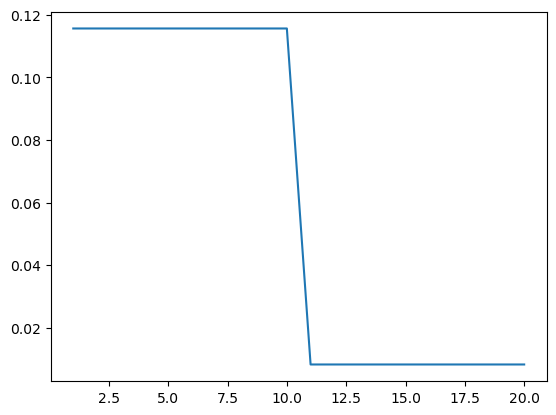

In [4]:
import matplotlib.pyplot as plt

# Calculate Regret

regret = np.max(y) - current_bests

plt.plot(range(1, num_iter+1), regret, label='Best Observed')